In [2]:
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
from sklearn.datasets import fetch_openml

In [6]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [7]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [8]:
y.shape

(70000,)

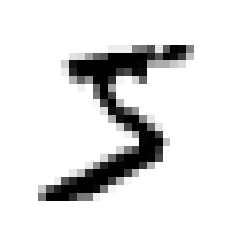

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [10]:
y[0]

'5'

In [11]:
y = y.astype(np.uint8)
y[0]

5

 Create a test test and training set (MNIST already does that - and it is also shuffled to guarantee that all numbers exist in both sets)

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [13]:
# training a binary classifier
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [14]:
# Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [15]:
sgd_clf.predict([some_digit])

array([ True])

## Performance 

In [16]:
# implementing cross-validation
def cross_validation():
    from sklearn.model_selection import StratifiedKFold
    from sklearn.base import clone
    
    skfolds = StratifiedKFold(n_splits=3, random_state=42)
    
    for train_index, test_index in skfolds.split(X_train, y_train_5):
        clone_clf = clone(sgd_clf)
        X_train_folds = X_train[train_index]
        y_train_folds = y_train_5[train_index]
        X_test_fold = X_train[test_index]
        y_test_fold = y_train_5[test_index]
        
        clone_clf.fit(X_train_folds, y_train_folds)
        y_pred = clone_clf.predict(X_test_fold)
        n_correct = sum(y_pred == y_test_fold)
        print(n_correct/len(y_pred))

In [17]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [18]:
# another model
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self,X, y=None):
        return self
    def predict(self,X):
        return np.zeros((len(X), 1), dtype=bool)

In [19]:
never_5_clf = Never5Classifier()

In [20]:
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy") 
# it seems to work well because 90% of all images are not 5

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix
Count the number of times intances of a class A are classified as class B

In [21]:
from sklearn.model_selection import cross_val_predict # makes predictions
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [23]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [25]:
# true positive rate
from sklearn.metrics import precision_score, recall_score

In [29]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [30]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [31]:
from sklearn.metrics import f1_score

In [32]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [33]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [34]:
threshold = 0

In [37]:
y_some_digit_pred = (y_scores>threshold)

In [38]:
y_some_digit_pred 

array([ True])

In [39]:
threshold = 8000
y_some_digit_pred = (y_scores>threshold)

In [40]:
y_some_digit_pred #confirms that raising the threshold decreases recall

array([False])

Deciding what threshold will be used:

In [41]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [43]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [74]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    p1, = plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    p2, = plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.grid()
    plt.rcParams["figure.figsize"] = (16, 6)
    plt.legend([p1, p2], ["Precision", "Recall"])

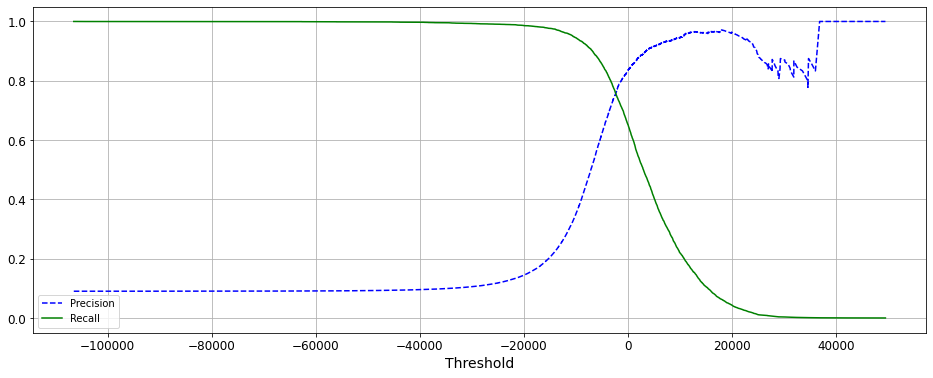

In [75]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Another option: Plot precision directly against recall

In [79]:
# I need 90% precision
threshold_90_precision = thresholds[np.argmax(precisions>= 0.90)]
threshold_90_precision

3370.0194991439557

In [80]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [81]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [82]:
recall_score(y_train_5, y_train_pred_90) #too low...

0.4799852425751706

ROC Curve - Receiver Operating Characteristic curve

In [83]:
from sklearn.metrics import roc_curve
fpr,tpr, thresholds = roc_curve(y_train_5, y_scores)

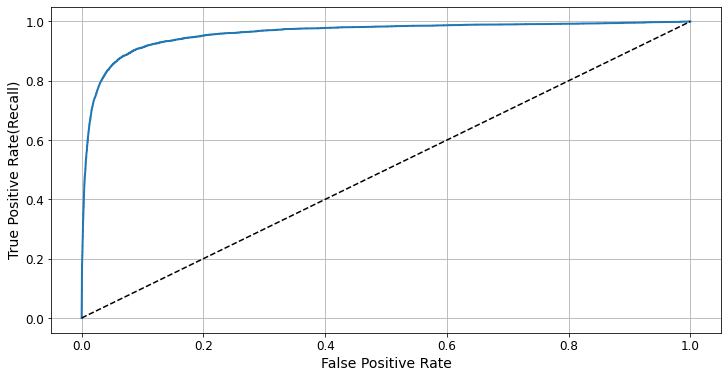

In [88]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--') #dashed diagonal (ROC curve)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate(Recall)")
    plt.grid()
    plt.rcParams["figure.figsize"] = (8, 6)
    
plot_roc_curve(fpr,tpr)
plt.show()